In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

In [4]:
log_path = Path.cwd() / "ezprofiler.log"
df = pd.read_csv(log_path, header=None, names=["Arrival", "Topic", "Sample"])
df

In [5]:
# Some pre-processing
min_time = min(df["Arrival"].min(), df["Sample"].min())
df["Arrival"] = df["Arrival"] - min_time
df["Sample"] = df["Sample"] - min_time


# Remove preceding SYSTEM and AGORA and trailing /OUTPUT_SIGNAL from Topic
def clean_topic(topic: str):
    if topic.startswith("SYSTEM/"):
        topic = topic[7:]
    if topic.startswith("AGORA/"):
        topic = topic[6:]
    if topic.endswith("/OUTPUT_SIGNAL"):
        topic = topic[:-14]
    if topic.endswith("/OUTPUT"):
        topic = topic[:-7]
    return topic


df["Topic"] = df["Topic"].apply(clean_topic)

# Remove WINDOW rows
df = df[not df["Topic"].str.endswith("EWM/WINDOW")]
df = df[not df["Topic"].str.endswith("/WINDOW")]

print(df["Topic"].unique())
df

['EEG_INLET' 'SELECT_BIO' 'BPFILTER' 'SGEYESUB' 'LPFILTER' 'DROPEOG' 'CAR'
 'DOWNSAMP' 'MOCAP_INLET' 'WINDOW' 'MARKER_INLET' 'MODEL']


,Arrival,Topic,Sample
0,1.705528e+09,EEG_INLET,0.461999
1,1.705528e+09,EEG_INLET,0.463999
2,1.705528e+09,EEG_INLET,0.465999
3,1.705528e+09,EEG_INLET,0.467999
4,1.705528e+09,EEG_INLET,0.469999
...,...,...,...
89161,1.705528e+09,DOWNSAMP,30.480357
89162,1.705528e+09,WINDOW,29.940357
89163,1.705528e+09,MODEL,29.940357
89164,1.705528e+09,MOCAP_INLET,30.489718


In [11]:
# Provide known order
# known_order = [
#     "RAWINGEST",
#     "PREPROC/BPFILT", "PREPROC/DOWNSAMPLE", "PREPROC/CAR",
#     #"PREPROC/EWM/EWM",
#     "PREPROC/EWM",
#     "FEATUREEXTRACT/BP/SPECGRAM/WINDOW", "FEATUREEXTRACT/BP/SPECGRAM/SPECTRUM",
#     "FEATUREEXTRACT/BP/SPECGRAM/MODIFYAXIS", "FEATUREEXTRACT/BP/BANDS",
#     # "FEATUREEXTRACT/EWM/EWM",
#     "FEATUREEXTRACT/EWM",
#     "DECODE/WINDOW", "DECODE/MODEL", "DECODE/MODIFYAXIS"
# ]
known_order = [
    "EEG_INLET",
    "SELECT_BIO",
    "BPFILTER",
    "SGEYESUB",
    "LPFILTER",
    "DROPEOG",
    "CAR",
    "DOWNSAMP",
    "WINDOW",
]


def plot_topic_times(
    _df: pd.DataFrame,
    x_field: str = "Arrival",
    y_field: str = "Sample",
    log_y=False,
    x_range=None,
):
    if x_field == "Arrival":
        _df[x_field] -= _df[x_field].min()
    # Plot x=Arrival vs y=Sample, independently for each Topic in known order.
    plt.figure(figsize=(8, 8))
    for topic in known_order:
        sub_df = _df[_df["Topic"] == topic]
        x = sub_df[x_field].values
        y = sub_df[y_field].values
        if x_range is not None:
            import numpy as np

            b_range = np.logical_and(x >= x_range[0], x <= x_range[1])
            x = x[b_range]
            y = y[b_range]
        if log_y:
            plt.semilogy(x, y, label=topic)
        else:
            plt.plot(x, y, label=topic)

    plt.xlabel(x_field)
    plt.ylabel(y_field)
    plt.legend()

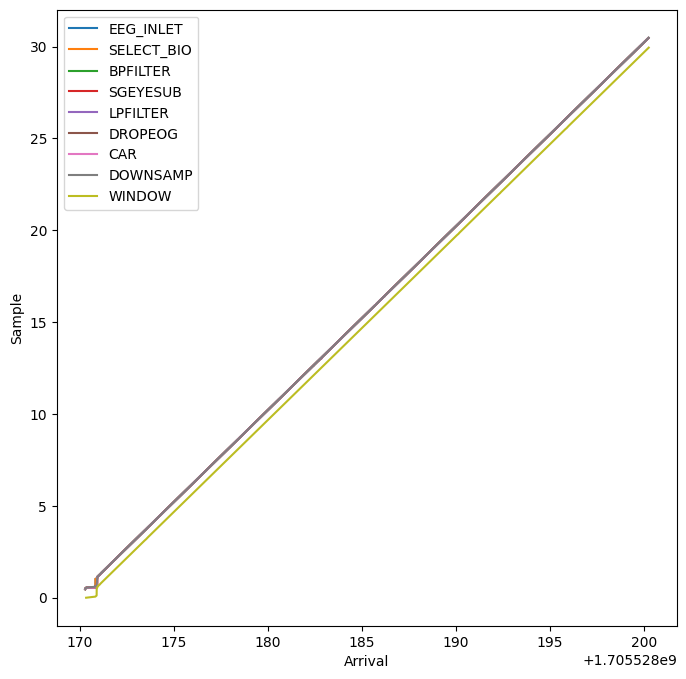

In [7]:
plot_topic_times(df)

In [30]:
from scipy.interpolate import PchipInterpolator

# Train pchip or nearest interp func using x=Arrival, y=Sample for RAWINGEST
ref_df = df[df["Topic"] == known_order[0]]
pchip = PchipInterpolator(ref_df["Arrival"].values, ref_df["Sample"].values)
# Create new column Delta = interp_func(arrival) - Sample
df["Delta"] = pchip(df["Arrival"].values) - df["Sample"].values

(-0.001, 0.005)

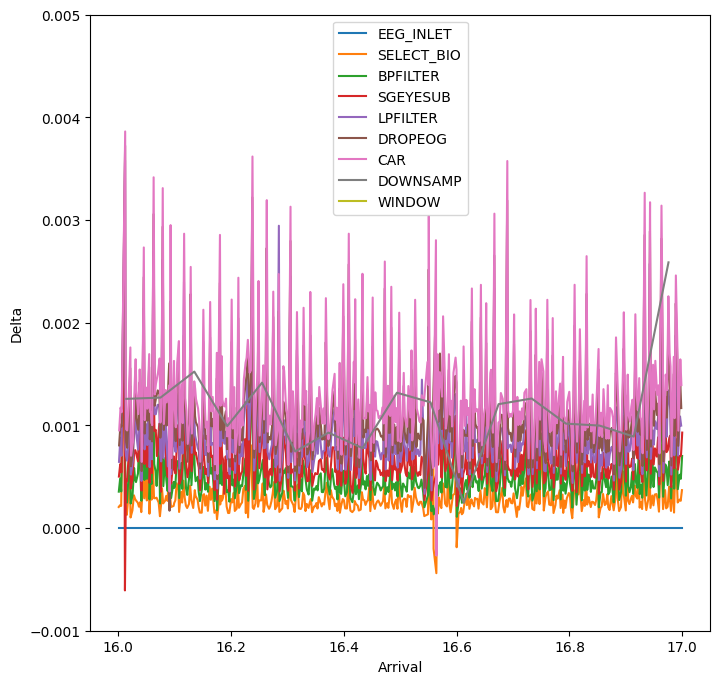

In [19]:
# Plot x=Arrival vs y=Delta, for each Topic
plot_topic_times(df, y_field="Delta", log_y=False, x_range=(16, 17))
# 0 - 0.01: BPFILT -> DOWNSAMPLE -> CAR ---> EWM (0.03 but highly variable)
plt.ylim([-0.001, 0.005])
# ~0.55: SPECGRAM/WINDOW -> SPECGRAM/SPECTRUM -> SPECGRAM/MODIFYAXIS -> BP/BANDS -> EWM
# plt.ylim([0.54, 0.55])
# 0.605-: DECODE/WINDOW
# plt.ylim([0.6, 0.61])
# ~0.757: DECODE/MODEL -> DECODE/MODIFYAXIS
# plt.ylim([0.74, 0.752])

In [38]:
log_path = Path.cwd() / "ezprofiler.log"
df = pd.read_csv(log_path, header=None, names=["Arrival", "Topic", "Sample"])
df

,Arrival,Topic,Sample
0,1.706229e+09,SOURCE/OUTPUT_SIGNAL,1.706229e+09
1,1.706229e+09,DUMMY1/OUTPUT_SIGNAL,1.706229e+09
2,1.706229e+09,DUMMY2/OUTPUT_SIGNAL,1.706229e+09
3,1.706229e+09,SOURCE/OUTPUT_SIGNAL,1.706229e+09
4,1.706229e+09,DUMMY2/OUTPUT_SIGNAL,1.706229e+09
...,...,...,...
844,1.706229e+09,DUMMY1/OUTPUT_SIGNAL,1.706229e+09
845,1.706229e+09,DUMMY2/OUTPUT_SIGNAL,1.706229e+09
846,1.706229e+09,SOURCE/OUTPUT_SIGNAL,1.706229e+09
847,1.706229e+09,DUMMY1/OUTPUT_SIGNAL,1.706229e+09


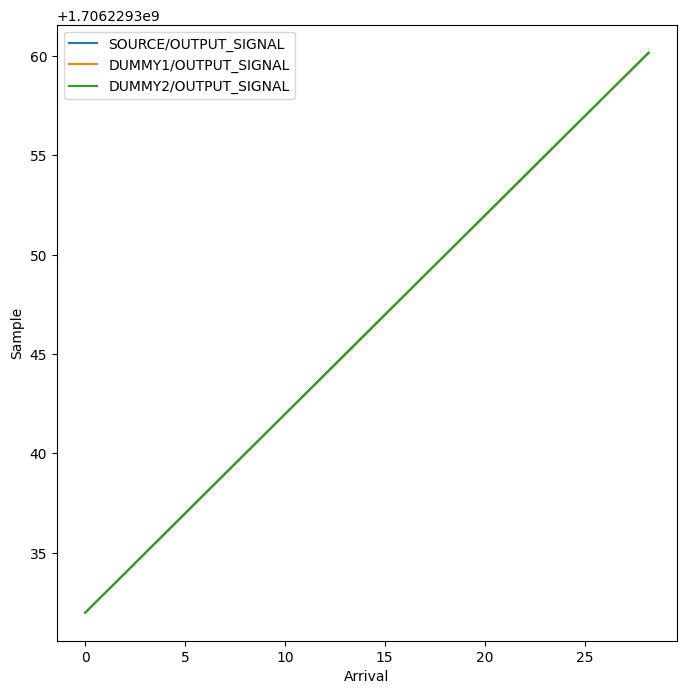

In [39]:
known_order = ["SOURCE/OUTPUT_SIGNAL", "DUMMY1/OUTPUT_SIGNAL", "DUMMY2/OUTPUT_SIGNAL"]
plot_topic_times(df)

(-0.001, 0.018)

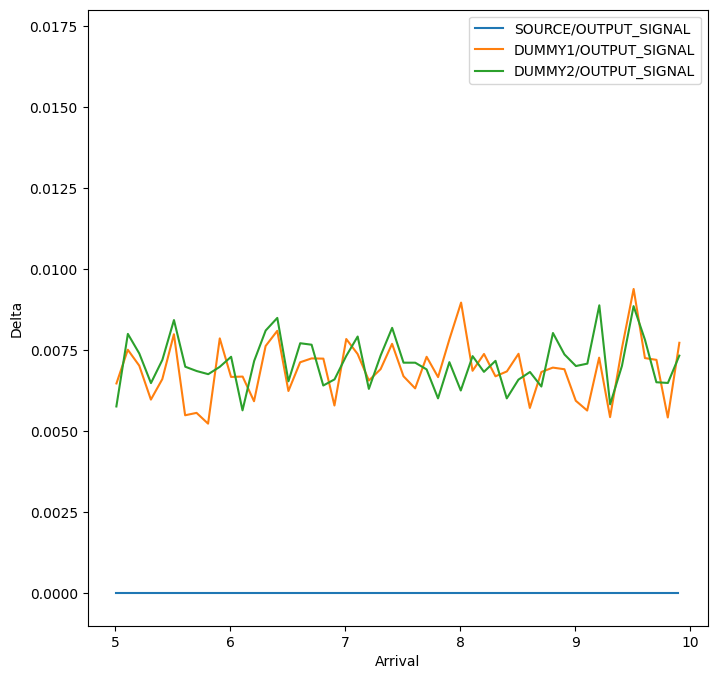

In [41]:
ref_df = df[df["Topic"] == known_order[0]]
pchip = PchipInterpolator(ref_df["Arrival"].values, ref_df["Sample"].values)
df["Delta"] = pchip(df["Arrival"].values) - df["Sample"].values
plot_topic_times(df, y_field="Delta", log_y=False, x_range=(5, 10))
plt.ylim([-0.001, 0.018])

Here are the results from the throughput tests.

| Test | Msg Size (bytes) | Buffers | Msg Rate (Hz) | Mean latency (s) | Data rate (MB/s) |
|------|------------------|---------|---------------|------------------|------------------|
| 1    | 32               | 2       | 11694         | 0.00015          | 0.374            |
| 2    | 32               | 32      | 22325         | 0.00016          | 0.714            |
| 3    | 512              | 2       | 11760         | 0.00014          | 6.021            |
| 4    | 512              | 32      | 21821         | 0.00016          | 11.172           |
| 5    | 8192             | 2       | 11764         | 0.00014          | 96.371           |
| 6    | 8192             | 32      | 21795         | 0.00016          | 178              |
| 7    | 131072           | 2       | 11439         | 0.00014          | 1499             |
| 8    | 131072           | 32      | 20251         | 0.00016          | 2654             |
| 9    | 2097152          | 2       | 6620          | 0.00023          | 13883            |
| 10   | 2097152          | 32      | 6596          | 0.00023          | 13834            |
| 11   | 32               | 2       | 47            | 0.064            | 0.001            |
| 12   | 32               | 32      | 8137          | 0.00063          | 0.260            |
| 13   | 512              | 2       | 47            | 0.0638           | 0.0243           |
| 14   | 512              | 32      | 8295          | 0.00050          | 4.247            |
| 15   | 8192             | 2       | 66            | 0.0456           | 0.543            |
| 16   | 8192             | 32      | 7893          | 0.00057          | 64.661           |
| 17   | 131072           | 2       | 47            | 0.064            | 6.22             |
| 18   | 131072           | 32      | 2441          | 0.0096           | 320              |
| 19   | 2097152          | 2       | 47            | 0.0637           | 98.8             |
| 20   | 2097152          | 32      | 744           | 0.0323           | 1561             |

In [22]:
perf_cols = (
    "Machine",
    "Msg Size (bytes)",
    "buffers",
    "Msg Rate (Hz)",
    "Latency (s)",
    "Data Rate (MB/s)",
)
perf_data = (
    ("M1Pro", 32, 2, 11694, 0.00015, 0.374),
    ("M1Pro", 32, 32, 22325, 0.00016, 0.714),
    ("M1Pro", 512, 2, 11760, 0.00014, 6.021),
    ("M1Pro", 512, 32, 21821, 0.00016, 11.172),
    ("M1Pro", 8192, 2, 11764, 0.00014, 96.371),
    ("M1Pro", 8192, 32, 21795, 0.00016, 178),
    ("M1Pro", 131072, 2, 11439, 0.00014, 1499),
    ("M1Pro", 131072, 32, 20251, 0.00016, 2654),
    ("M1Pro", 2097152, 2, 6620, 0.00023, 13883),
    ("M1Pro", 2097152, 32, 6596, 0.00023, 13834),
    ("RPi5", 32, 2, 47, 0.064, 0.001),
    ("RPi5", 32, 32, 8137, 0.00063, 0.260),
    ("RPi5", 512, 2, 47, 0.0638, 0.0243),
    ("RPi5", 512, 32, 8295, 0.00050, 4.247),
    ("RPi5", 8192, 2, 66, 0.0456, 0.543),
    ("RPi5", 8192, 32, 7893, 0.00057, 64.661),
    ("RPi5", 131072, 2, 47, 0.064, 6.22),
    ("RPi5", 131072, 32, 2441, 0.0096, 320),
    ("RPi5", 2097152, 2, 47, 0.0637, 98.8),
    ("RPi5", 2097152, 32, 744, 0.0323, 1561),
)

perf_df = pd.DataFrame(perf_data, columns=perf_cols)
perf_df

,Machine,Msg Size (bytes),buffers,Msg Rate (Hz),Latency (s),Data Rate (MB/s)
0,M1Pro,32,2,11694,0.00015,0.3740
1,M1Pro,32,32,22325,0.00016,0.7140
2,M1Pro,512,2,11760,0.00014,6.0210
3,M1Pro,512,32,21821,0.00016,11.1720
4,M1Pro,8192,2,11764,0.00014,96.3710
5,M1Pro,8192,32,21795,0.00016,178.0000
6,M1Pro,131072,2,11439,0.00014,1499.0000
7,M1Pro,131072,32,20251,0.00016,2654.0000
8,M1Pro,2097152,2,6620,0.00023,13883.0000
9,M1Pro,2097152,32,6596,0.00023,13834.0000


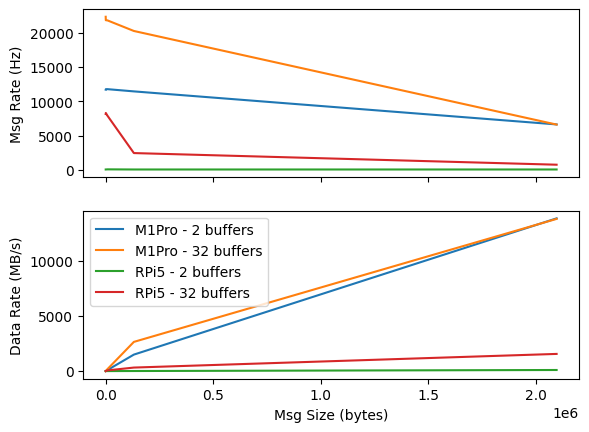

In [26]:
fig, axes = plt.subplots(2, 1, sharex=True)
for mach in perf_df["Machine"].unique():
    for n_buffs in perf_df["buffers"].unique():
        sub_df = perf_df[(perf_df["Machine"] == mach) & (perf_df["buffers"] == n_buffs)]
        axes[0].plot(
            sub_df["Msg Size (bytes)"],
            sub_df["Msg Rate (Hz)"],
            label=f"{mach} - {n_buffs} buffers",
        )
        axes[1].plot(
            sub_df["Msg Size (bytes)"],
            sub_df["Data Rate (MB/s)"],
            label=f"{mach} - {n_buffs} buffers",
        )

axes[1].set_xlabel("Msg Size (bytes)")
axes[0].set_ylabel("Msg Rate (Hz)")
axes[1].set_ylabel("Data Rate (MB/s)")
axes[1].legend()